# Last Value Estimator that is Scikit-Learn compatible

In [1]:
import xgboost
import sklearn
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.model_selection import OptunaCVOptimizer
from quantbullet.model import LastValueEstimator, TypicalHyperparameterRanges
from quantbullet.model_selection import TimeSeriesDailyRollingSplit

+-------------------------+
|  Package : quantbullet  |
|  Author  : Yiming Zhang |
|  Version : 0.1.0        |
|  Note    : BETA version |
+-------------------------+


/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the sunspots dataset
sunspots = sm.datasets.sunspots.load_pandas().data

# Create a new feature by shifting the sunspots count
sunspots['lagged_sunspots'] = sunspots['SUNACTIVITY'].shift(1)

# Drop the first row which will have a NaN value in the 'lagged_sunspots' column
sunspots = sunspots.iloc[1:]

# Reset the index and rename the column
sunspots_reset = sunspots.reset_index().rename(columns={'index': 'date'})

X = sunspots_reset[['YEAR', 'date', 'lagged_sunspots']]
y = sunspots_reset['SUNACTIVITY']

In [13]:
X.head()

,YEAR,date,lagged_sunspots
0,1701.0,1,5.0
1,1702.0,2,11.0
2,1703.0,3,16.0
3,1704.0,4,23.0
4,1705.0,5,36.0


## A Simple Backtest

The time series splitter splits the train and test sets by dates, using at least 100 data as training set and the next immediate date as the test set. Though we use cross validation functionality, it is actually a backtest. The Last Value Estimator is a simple estimator that provides a baseline using previous date average as the prediction for the next date.

In [3]:
ts_split = TimeSeriesDailyRollingSplit(min_train_size=100).split(X)

last_value_estimator_abs_error = cross_val_score(
    LastValueEstimator(reference_column="date"),
    X,
    y,
    cv=ts_split,
    scoring="neg_mean_absolute_error",
)

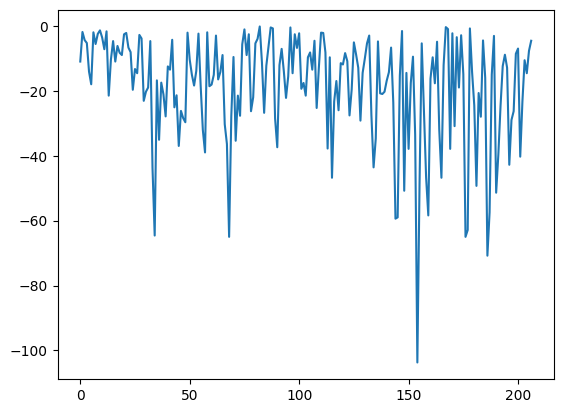

In [4]:
plt.plot(last_value_estimator_abs_error)

In [5]:
import numpy as np
ts_split = TimeSeriesDailyRollingSplit(min_train_size=100)
estimator = LastValueEstimator('date')
predictions = np.full(y.shape, np.nan)

# Loop over the splits
for train_index, test_index in ts_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the estimator and make predictions
    estimator.fit(X_train, y_train)
    predictions[test_index] = estimator.predict(X_test)

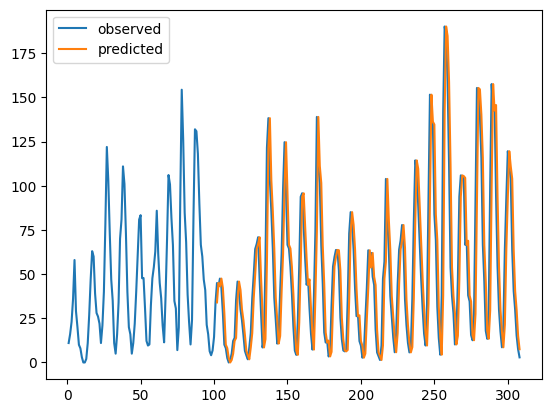

In [6]:
plt.plot(sunspots_reset['date'], sunspots_reset['SUNACTIVITY'], label='observed')
plt.plot(sunspots_reset['date'], predictions, label='predicted')
plt.legend()

## XGBoost Model

Next, we try to use XGBoost to do the same task. An optuna study is used to find the best hyperparameters for the model.

- `objective`: is the xgboost objective function used in training.
- `scoring`: is the scoring function for the cross validation (in our case the backtesting) used by `scikit-learn`.

In [7]:
tuning_params = TypicalHyperparameterRanges.xgboost
tuning_params['max_depth'].insert(0, 1)
tuning_params['n_estimators'].insert(0, 2)

In [8]:
ts_split = list(TimeSeriesDailyRollingSplit(min_train_size=100).split(X))
optimizer = OptunaCVOptimizer(
    X=X,
    y=y,
    model=xgboost.XGBRegressor(random_state=42),
    cv=ts_split,
    objective="reg:absoluteerror",
    scoring="neg_mean_absolute_error",
)

In [9]:
optimizer.optimize(
    fixed_params={},
    tuning_params=tuning_params,
    n_trials=10)

Best trial: 9. Best value: -19.6251: 100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


In this tiny dataset, the XGBoost model is not better than the Last Value Estimator. The feature is too simple.

In [10]:
ts_split = TimeSeriesDailyRollingSplit(min_train_size=100).split(X)

model = xgboost.XGBRegressor(objective="reg:absoluteerror",
                             random_state=42,
                             **optimizer.best_params)

xgboost_abs_error = cross_val_score(
    model,
    X,
    y,
    cv=ts_split,
    scoring="neg_mean_absolute_error",
)
    

In [11]:
np.mean(xgboost_abs_error), np.mean(last_value_estimator_abs_error)

(-19.625129190159303, -18.70193236714976)